In [1]:
!pip install us
import us
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

     |████████████████████████████████| 132 kB 5.4 MB/s 
  Created wheel for us: filename=us-2.0.2-py3-none-any.whl size=11942 sha256=5dfe9695387019b678f425e3add2162fdca9187be897cced981684f914e01da1
  Stored in directory: /root/.cache/pip/wheels/ca/6b/11/cda9ea2438f721330a35c9a2c8e34b4aedcd34c89af48a4d00
  Created wheel for jellyfish: filename=jellyfish-0.6.1-cp37-cp37m-linux_x86_64.whl size=72179 sha256=4f108fc6cd9ed4bae8808774e6f508d13a4bba5daf7484ed8ae359205713d379
  Stored in directory: /root/.cache/pip/wheels/a1/99/51/7de469e37cd1b3c763c24394e1ebf1baa2d79e094bf346cf80
Successfully built us jellyfish


In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [29]:
%cd /content/drive/Shareddrives/Data606_Energy/data/weather

/content/drive/Shareddrives/Data606_Energy/data/weather


In [30]:
temp_df = pd.read_csv('temperatures_1981-01-01-2021-10-01.csv')
pop_temp_df = pd.read_csv('population_density_at_temperature_coordinates.csv')
pdsi_df = pd.read_csv('pdsi_1981-01-01-2021-10-01.csv')
pop_drought_df = pd.read_csv('population_density_at_drought_coordinates.csv')

In [31]:
pop_temp_df['State'] = [us.states.lookup(s).abbr for s in temp_df['State']]

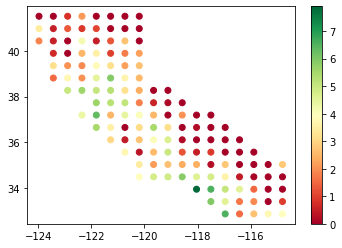

In [32]:
# just to show a sample of what this log density stuff looks like
ca_pop = pop_temp_df[(pop_temp_df['State']=='CA')]#&(pop_temp_df['Average Density']>15)]
plt.scatter(ca_pop['x'],ca_pop['y'],c=np.log(np.maximum(np.ones(ca_pop.shape[0]),np.array(ca_pop['Average Density']))),cmap='RdYlGn')
plt.colorbar()

## Function to convert a dataframes values into standardardized values based on historical mean and standard deviation. Returns the standardized values as well as the means and standard deviations

In [33]:
def standardize_data(data,date_start):
  # first, I need to create an array that holds the average as time goes by during the time range of interest
  # I need to do the same thing with the standard deviations
  cols = data.columns[1:-3] # excluding 1st column and last 3
  cols = pd.to_datetime(cols,format='%Y-%m-%d')
  data.columns = ['Untitled']+list(cols)+['y','x','State']
  cols_for_average = cols[cols<date_start]
  df_for_average = data.copy()[cols_for_average]
  # specify which columns are to be standardized
  cols_for_analysis = cols[cols>=date_start]
  data_for_analysis = data.copy()[cols_for_analysis]
  # grab the averages and standard deviations by coordinate and by month
  month_summaries = {}
  for m in range(1,13):
    month_columns = cols_for_average[[col.month == m for col in cols_for_average]]
    month_avgs = df_for_average[month_columns].mean(axis=1)
    month_stds = df_for_average[month_columns].std(axis=1)
    month_summaries[f'Averages {m}'] = month_avgs
    month_summaries[f'Standard Deviations {m}'] = month_stds
    month_columns_standardize = cols_for_analysis[[col.month == m for col in cols_for_analysis]]
    # now standardize the data used for analysis using these averages and standard deviations
    for col in month_columns_standardize:
      data_for_analysis[col] = (data_for_analysis[col]-month_avgs)/month_stds
  data_for_analysis[['y','x','State']] = data[['y','x','State']]
  month_summaries['x']=data_for_analysis['x']
  month_summaries['y']=data_for_analysis['y']
  month_summaries['State']=data_for_analysis['State']
  return data_for_analysis, pd.DataFrame(month_summaries)

### Get convert data from 2000 onward into standard deviations above average

In [34]:
standardized_temperatures, temp_summary = standardize_data(temp_df,'2000-01-01')
standardized_droughts, drought_summary = standardize_data(pdsi_df,'2000-01-01')

In [35]:
# first I need to make the column names into datetimes so that I can subset stuff on months
date_cols = standardized_temperatures.columns[:-3] # emit the last 3 cause they're coordinates and States
date_cols = pd.to_datetime(date_cols,format='%Y-%m-%d')
standardized_temperatures.columns = list(date_cols)+['y','x','State']
# standardize each of the dataframes
date_cols = standardized_droughts.columns[:-3] # emit the last 3 cause they're coordinates and States
date_cols = pd.to_datetime(date_cols,format='%Y-%m-%d')
standardized_droughts.columns = list(date_cols)+['y','x','State']

In [36]:
standardized_temperatures.head()

,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,y,x,State
0,0.195069,0.008212,0.542134,-0.099071,-1.263220,1.355255,-1.355001,-0.156775,0.295289,0.336192,0.231562,0.965054,0.539950,1.417825,-0.235910,0.161477,-1.733667,0.276314,-0.940999,-0.949220,0.459242,-0.693373,0.535062,0.368379,-0.795404,-0.496381,2.568848,0.355922,1.238312,-0.766687,-0.494775,-0.033940,1.455358,1.350557,1.228551,2.029864,0.779507,-0.382636,0.047932,1.272985,...,-2.106060,0.775329,-0.842690,1.385419,1.903498,1.316913,0.570158,0.383676,2.080495,3.560159,0.635884,1.254443,0.187068,2.321077,0.959672,2.646459,2.240785,2.096054,1.275728,-0.416964,-1.575853,1.155236,1.010875,0.238713,0.366593,-1.750719,1.230021,1.166424,1.705080,2.059590,1.300329,0.531345,-1.220812,0.349684,0.345036,0.179930,0.320230,71.146571,-156.845849,Alaska
1,0.229799,0.084691,0.570635,-0.121588,-1.269277,1.982208,-0.923468,0.000120,0.322423,0.312269,0.213154,0.997385,0.518398,1.377912,-0.296399,0.153562,-1.820193,0.522424,-0.817209,-0.799934,0.440162,-0.760378,0.558782,0.301605,-0.847112,-0.582006,2.452279,0.346559,1.143007,-0.493047,-0.842272,0.274886,1.492715,1.316731,1.215640,2.106060,0.763110,-0.441068,-0.035193,1.190013,...,-2.016151,1.278024,-0.793160,1.343480,1.814703,1.288897,0.561481,0.324017,2.035533,3.486195,0.632646,1.262242,-0.397942,2.288377,1.211037,2.763874,2.211329,2.070737,1.244128,-0.343043,-1.615594,1.112115,0.994381,0.206089,-0.076209,-1.650540,1.330749,1.233127,1.602910,2.064603,1.249781,0.449425,-1.286125,0.322851,0.254289,0.255888,0.199475,71.146571,-156.306859,Alaska
2,0.213839,0.142913,0.633141,-0.123425,-1.264391,1.925228,-0.923456,-0.078843,0.275176,0.277998,0.252611,1.038400,0.565449,1.360920,-0.281803,0.126567,-1.838874,0.492469,-0.816983,-0.790820,0.442558,-0.725390,0.560192,0.270207,-0.870147,-0.543279,2.428608,0.346430,1.165701,-0.388580,-0.856394,0.221360,1.488662,1.273068,1.265913,2.125463,0.766742,-0.354093,0.002695,1.170158,...,-2.122100,1.285869,-0.894485,1.289650,1.803027,1.323934,0.676521,0.416652,2.060172,3.590126,0.644761,1.242324,-0.331961,2.097792,0.938290,2.683797,2.150591,1.984693,1.189231,-0.352041,-1.580315,1.136193,0.968015,0.162689,-0.068007,-1.732740,1.103848,1.178243,1.622070,2.049627,1.370200,0.490209,-1.221262,0.375662,0.278977,0.250552,0.245440,71.146571,-155.767870,Alaska
3,-0.058758,0.154317,0.210616,0.011210,-1.261560,0.198878,-2.229658,-0.417110,0.102771,0.278783,0.225094,0.802836,0.509141,1.428701,-0.127763,0.036756,-1.837890,-0.819211,-1.850839,-1.030695,0.650

In [37]:
# first make sure the coordinates match up so I can add the population density as a column to the temperature and drought dataframes
print(sum(standardized_temperatures['y'] != pop_temp_df['y']))
print(sum(standardized_droughts['y'] != pop_drought_df['y']))

0
0


In [38]:
# bring over the population densities per location
standardized_temperatures['Population Density'] = pop_temp_df['Average Density']
standardized_droughts['Population Density'] = pop_drought_df['Average Density']

### Come up with some factor to multiply the values by so that areas with less population don't count as much and areas with more population count more.

#### Idea number 1 - divide each coorinates population density by the mean population density of that state overall.
  Pros - it will have state specific factors
  
  Cons - if a state gets energy from another state, the states levels of population density may not be as important as the state that it gets its energy from

Overall, I think this approach should be fine unless we want to make things really complicated and we honestly don't have all the necessary information to do a more in depth factor.

In [39]:
# first get the log density of each location
pop_temp_df['log density'] = np.log(np.maximum(np.ones(pop_temp_df.shape[0]),np.array(pop_temp_df['Average Density'])))
pop_drought_df['log density'] = np.log(np.maximum(np.ones(pop_drought_df.shape[0]),np.array(pop_drought_df['Average Density'])))

In [40]:
# get the state specific sum of log density
pop_temp_df['State'] = temp_df['State']
state_sum_log_densities_temp = pop_temp_df[['log density','State']].groupby(by='State').sum()
state_sum_densities_temp = pop_temp_df[['Average Density','State']].groupby(by='State').sum()
pop_drought_df['State'] = pdsi_df['State']
state_sum_log_densities_drought = pop_drought_df[['log density','State']].groupby(by='State').sum()
state_sum_densities_drought = pop_drought_df[['Average Density','State']].groupby(by='State').sum()

In [41]:
# get the dictionaries for the sum of the log densities
state_sum_log_temps = {}
for i in range(state_sum_log_densities_temp.shape[0]):
  state_sum_log_temps[state_sum_log_densities_temp.index[i]] = state_sum_log_densities_temp['log density'].iloc[i]

state_sum_log_droughts = {}
for i in range(state_sum_log_densities_drought.shape[0]):
  state_sum_log_droughts[state_sum_log_densities_drought.index[i]] = state_sum_log_densities_drought['log density'].iloc[i]

# get the dictionaries for the sum of the densities
state_sum_temps = {}
for i in range(state_sum_densities_temp.shape[0]):
  state_sum_temps[state_sum_densities_temp.index[i]] = state_sum_densities_temp['Average Density'].iloc[i]

state_sum_droughts = {}
for i in range(state_sum_densities_drought.shape[0]):
  state_sum_droughts[state_sum_densities_drought.index[i]] = state_sum_densities_drought['Average Density'].iloc[i]

In [42]:
# add the state grouped means
standardized_temperatures['State Sum Log'] = [state_sum_log_temps[s] for s in standardized_temperatures['State']]
standardized_temperatures['State Sum'] = [state_sum_temps[s] for s in standardized_temperatures['State']]
standardized_temperatures['log density'] = pop_temp_df['log density']
standardized_temperatures['Log Factor'] = standardized_temperatures['log density']/standardized_temperatures['State Sum Log']
standardized_temperatures['Factor'] = standardized_temperatures['Population Density']/standardized_temperatures['State Sum']

standardized_droughts['State Sum Log'] = [state_sum_log_droughts[s] for s in standardized_droughts['State']]
standardized_droughts['State Sum'] = [state_sum_droughts[s] for s in standardized_droughts['State']]
standardized_droughts['log density'] = pop_drought_df['log density']
standardized_droughts['Log Factor'] = standardized_droughts['log density']/standardized_droughts['State Sum Log']
standardized_droughts['Factor'] = standardized_droughts['Population Density']/standardized_droughts['State Sum']

In [43]:
log_weighted_temperatures = standardized_temperatures.copy()
log_weighted_droughts = standardized_droughts.copy()
weighted_temperatures = standardized_temperatures.copy()
weighted_droughts = standardized_droughts.copy()

In [44]:
weighted_temperatures.head()

,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,...,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,y,x,State,Population Density,State Sum Log,State Sum,log density,Log Factor,Factor
0,0.195069,0.008212,0.542134,-0.099071,-1.263220,1.355255,-1.355001,-0.156775,0.295289,0.336192,0.231562,0.965054,0.539950,1.417825,-0.235910,0.161477,-1.733667,0.276314,-0.940999,-0.949220,0.459242,-0.693373,0.535062,0.368379,-0.795404,-0.496381,2.568848,0.355922,1.238312,-0.766687,-0.494775,-0.033940,1.455358,1.350557,1.228551,2.029864,0.779507,-0.382636,0.047932,1.272985,...,0.570158,0.383676,2.080495,3.560159,0.635884,1.254443,0.187068,2.321077,0.959672,2.646459,2.240785,2.096054,1.275728,-0.416964,-1.575853,1.155236,1.010875,0.238713,0.366593,-1.750719,1.230021,1.166424,1.705080,2.059590,1.300329,0.531345,-1.220812,0.349684,0.345036,0.179930,0.320230,71.146571,-156.845849,Alaska,3.992714,49.826446,299.103598,1.384471,0.027786,1.334893e-02
1,0.229799,0.084691,0.570635,-0.121588,-1.269277,1.982208,-0.923468,0.000120,0.322423,0.312269,0.213154,0.997385,0.518398,1.377912,-0.296399,0.153562,-1.820193,0.522424,-0.817209,-0.799934,0.440162,-0.760378,0.558782,0.301605,-0.847112,-0.582006,2.452279,0.346559,1.143007,-0.493047,-0.842272,0.274886,1.492715,1.316731,1.215640,2.106060,0.763110,-0.441068,-0.035193,1.190013,...,0.561481,0.324017,2.035533,3.486195,0.632646,1.262242,-0.397942,2.288377,1.211037,2.763874,2.211329,2.070737,1.244128,-0.343043,-1.615594,1.112115,0.994381,0.206089,-0.076209,-1.650540,1.330749,1.233127,1.602910,2.064603,1.249781,0.449425,-1.286125,0.322851,0.254289,0.255888,0.199475,71.146571,-156.306859,Alaska,3.437128,49.826446,299.103598,1.234636,0.024779,1.149143e-02
2,0.213839,0.142913,0.633141,-0.123425,-1.264391,1.925228,-0.923456,-0.078843,0.275176,0.277998,0.252611,1.038400,0.565449,1.360920,-0.281803,0.126567,-1.838874,0.492469,-0.816983,-0.790820,0.442558,-0.725390,0.560192,0.270207,-0.870147,-0.543279,2.428608,0.346430,1.165701,-0.388580,-0.856394,0.221360,1.488662,1.273068,1.265913,2.125463,0.766742,-0.354093,0.002695,1.170158,...,0.676521,0.416652,2.060172,3.590126,0.644761,1.242324,-0.331961,2.097792,0.938290,2.683797,2.150591,1.984693,1.189231,-0.352041,-1.580315,1.136193,0.968015,0.162689,-0.068007,-1.732740,1.103848,1.178243,1.622070,2.049627,1.370200,0.490209,-1.221262,0.375662,0.278977,0.250552,0.245440,71.146571,-155.767870,Alaska,0.000154,49.826446,299.103598,0.000000,0.000000,5.136791e-07
3,-0.058758,0.154317,0.210616,0.011210,-1.261560,0.198878,-2.229658,-0.417110,0.102771,0.278783,0.225094,0.802836,0.509141,1.428701,-0.127763,0.036756,-1.837890,-0.819211,-1.850839,-1.030695,0.650224,-0.617643,0.347530,0.136360,

In [45]:
# sanity check - make sure the values add up correctly and that each states factors sum to 1
print(weighted_temperatures['log density'].sum())
print(weighted_temperatures['State Sum Log'].unique().sum())

print(log_weighted_temperatures['log density'].sum())
print(log_weighted_temperatures['State Sum Log'].unique().sum())

print("Checking the Population Factors All Sum to 1")
print(weighted_droughts.groupby(by='State').sum()['Factor'].unique())
print(weighted_temperatures.groupby(by='State').sum()['Factor'].unique())

print("Checking the Log Population Factors All Sum to 1")
print(log_weighted_droughts.groupby(by='State').sum()['Log Factor'].unique())
print(log_weighted_temperatures.groupby(by='State').sum()['Log Factor'].unique())

5509.586756069127
5509.586756069128
5509.586756069127
5509.586756069128
Checking the Population Factors All Sum to 1
[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1.]
Checking the Log Population Factors All Sum to 1
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [46]:
# make a dataframe for the temperatures and droughts that are weighted by the densitweighted_temperatures = standardized_temperatures.copy()
for col in weighted_temperatures.columns[:-9]:
  weighted_temperatures[col] = weighted_temperatures[col]*weighted_temperatures['Factor']

for col in weighted_droughts.columns[:-9]:
  weighted_droughts[col] = weighted_droughts[col]*weighted_droughts['Factor']

# now do the same for the log weights
for col in log_weighted_temperatures.columns[:-9]:
  log_weighted_temperatures[col] = log_weighted_temperatures[col]*log_weighted_temperatures['Log Factor']

for col in log_weighted_droughts.columns[:-9]:
  log_weighted_droughts[col] = log_weighted_droughts[col]*log_weighted_droughts['Log Factor']

In [47]:
# now do some grouping by the state for the weighted dataframes
weighted_temperature_mean_grouped = weighted_temperatures.groupby(by='State').sum()
weighted_droughts_mean_grouped = weighted_droughts.groupby(by='State').sum()

# now do the same but for the log weighted stuff
log_weighted_temperature_mean_grouped = log_weighted_temperatures.groupby(by='State').sum()
log_weighted_droughts_mean_grouped = log_weighted_droughts.groupby(by='State').sum()

In [48]:
# do the grouping with the unweighted data too
temperature_mean_grouped = standardized_temperatures.groupby(by='State').mean()
temperature_mean_grouped['State'] = temperature_mean_grouped.index
temperature_mean_grouped = temperature_mean_grouped.reset_index(drop=True)

drought_mean_grouped = standardized_droughts.groupby(by='State').mean()
drought_mean_grouped['State'] = drought_mean_grouped.index
drought_mean_grouped = drought_mean_grouped.reset_index(drop=True)

In [49]:
temperature_mean_grouped.head()

,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,...,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,y,x,Population Density,State Sum Log,State Sum,log density,Log Factor,Factor,State
0,0.466668,0.982958,1.160907,-0.553321,1.850775,0.150626,1.332555,1.178462,-0.707629,0.517256,-0.772982,-1.983097,-1.014928,1.386059,-1.406095,0.672028,0.213238,-1.075246,-0.295270,-0.887028,-1.633541,-1.349302,1.394186,0.715409,0.612944,-1.289664,-0.201765,1.313796,0.173389,-0.140849,-0.175987,0.114111,1.322539,1.137048,-1.137417,-0.563601,-1.203946,-0.299120,0.782550,0.235206,...,0.407580,0.441312,2.940916,-0.165617,0.484622,2.247930,0.503418,0.521308,1.044180,4.618771,2.079677,-1.190239,0.855784,1.473924,0.892395,2.640889,0.300906,-0.549808,-0.106740,0.394972,0.573274,0.004077,1.194335,1.223751,-0.408364,0.516754,-0.767884,1.284090,-0.476497,-0.575919,-0.429932,32.627647,-86.839930,34.240621,134.497771,1472.346700,3.127855,0.023256,0.023256,Alabama
1,-0.353703,1.265361,0.605472,-0.010824,-1.170094,0.322748,-1.203339,-1.230108,-0.541490,0.136364,1.455904,1.000650,1.182543,1.142084,-0.363541,0.026445,-1.832911,0.019407,-1.355276,0.159009,0.596143,-0.657092,-0.239786,-1.002540,0.460812,0.242247,0.351528,-0.541807,0.302580,-0.236072,-0.460391,-0.074465,0.616100,1.861463,2.549034,1.077407,0.641435,1.256614,-0.482288,0.577734,...,0.541117,0.461864,1.312925,2.526033,0.699279,1.262244,2.295233,2.550460,0.986859,1.325510,1.786644,1.790013,0.040675,-1.210014,-0.418388,-0.115189,0.518637,1.373661,0.776434,-0.333137,1.241156,0.640067,1.587196,1.042527,0.617404,0.721225,-0.708153,-0.705443,-0.077424,0.416781,0.832756,64.226681,-152.427578,0.314184,49.826446,299.103598,0.052339,0.001050,0.001050,Alaska
2,1.476468,0.960940,-0.360003,1.038164,1.833147,0.633225,1.249609,0.472353,1.243857,-0.770764,-2.411842,1.215607,-0.908108,-0.852773,0.155752,-0.253098,1.706974,0.810660,0.019228,0.423912,1.493476,1.108979,1.227914,-0.887879,0.234076,0.429408,0.052070,1.193336,0.474995,1.604674,1.183374,1.079126,0.284102,-0.583769,0.599635,-0.402064,1.984794,0.004047,-0.307544,-0.448954,...,0.576087,-0.097695,-1.547463,0.288030,0.794156,-1.879519,0.328292,1.706135,2.366117,0.704710,-0.028494,0.940059,0.006785,0.313401,0.235227,0.069790,0.652420,2.106269,0.922147,2.073551,3.736596,2.179243,2.130404,1.501877,0.585880,0.411459,0.532808,-0.162261,1.177996,1.096992,2.175494,34.283152,-111.719840,18.405973,97.552961,1730.161494,1.037797,0.010638,0.010638,Arizona
3,0.816574,1.166947,1.266689,-0.256392,0.800917,-0.726578,0.178447,2.147981,0.852779,1.449348,-1.271609,-2.422504,-0.836774,0.341400,-1.780658,1.591819,0.243936,-0.540358,0.522347,0.168280,-0.900992,-1.203338,1.235297,0.63800

In [50]:
def give_column_names(df, to_add):
  new_columns = []
  for col in df.columns:
    if not 'State' in str(col) and not 'Year' in str(col):
      new_columns.append(to_add+str(col))
    else:
      new_columns.append(col)
  df.columns = new_columns
  return df

In [51]:
# function to get standardized data aggregated by state into a format for our analysis
def format_state_aggregate(df, date_cols, to_add):
  dates = []
  states = []
  values = []
  # go through each row and append the whole row to the various lists - essentially doing a pd.melt
  for i in range(df.shape[0]):
    states += [df['State'].iloc[i]]*len(date_cols)
    dates += list(date_cols)
    values += list(df.iloc[i][date_cols])
  new_formatted_weather = pd.DataFrame({'State':states,'Date':dates,'Values':values})
  new_formatted_weather.index = pd.to_datetime(new_formatted_weather['Date'],format='%Y-%m-%d')
  new_formatted_weather['Year'] = new_formatted_weather.index.year
  new_formatted_weather['Month'] = new_formatted_weather.index.month
  new_formatted_weather['State'] = [us.states.lookup(s).abbr for s in new_formatted_weather['State']]

  new_formatted_weather = new_formatted_weather.reset_index(drop=True)[['State','Year','Month','Values']].pivot(index=['State','Year'],columns='Month')
  new_formatted_weather.columns = new_formatted_weather.columns.get_level_values(1)
  new_formatted_weather['State'] = new_formatted_weather.index.get_level_values(0)
  new_formatted_weather['Year'] = new_formatted_weather.index.get_level_values(1)
  new_formatted_weather = new_formatted_weather.reset_index(drop=True)
  new_formatted_weather = give_column_names(new_formatted_weather,to_add)

  return new_formatted_weather

In [52]:
# format states to be abbreviations
temp_summary['State'] = [us.states.lookup(s).abbr for s in temp_summary['State']]
drought_summary['State'] = [us.states.lookup(s).abbr for s in drought_summary['State']]

In [53]:
temp_to_save = temp_summary.copy().groupby(by='State').mean().reset_index()
del temp_to_save['x']
del temp_to_save['y']

drought_to_save = drought_summary.copy().groupby(by='State').mean().reset_index()
del drought_to_save['x']
del drought_to_save['y']

In [54]:
# save the standardized values not aggregated by state yet in case we want to do further analysis at location level
standardized_temperatures.to_csv('standardized_temperatures.csv')
standardized_droughts.to_csv('standardized_droughts.csv')
# save the averages by state
format_state_aggregate(temperature_mean_grouped,list(temperature_mean_grouped.columns[:-9]),'Temp ').to_csv('standardized_temperatures_state.csv')
format_state_aggregate(drought_mean_grouped,list(drought_mean_grouped.columns[:-9]),'Drought ').to_csv('standardized_droughts_state.csv')
# save the means and standard deviations by location
give_column_names(temp_to_save,'Temp ').to_csv('temperature_summary.csv')
give_column_names(drought_to_save,'Drought ').to_csv('drought_summary.csv')

In [55]:
format_state_aggregate(temperature_mean_grouped,list(temperature_mean_grouped.columns[:-9]),'').head()

,1,2,3,4,5,6,7,8,9,10,11,12,State,Year
0,-0.353703,1.265361,0.605472,-0.010824,-1.170094,0.322748,-1.203339,-1.230108,-0.541490,0.136364,1.455904,1.000650,AK,2000
1,1.182543,1.142084,-0.363541,0.026445,-1.832911,0.019407,-1.355276,0.159009,0.596143,-0.657092,-0.239786,-1.002540,AK,2001
2,0.460812,0.242247,0.351528,-0.541807,0.302580,-0.236072,-0.460391,-0.074465,0.616100,1.861463,2.549034,1.077407,AK,2002
3,0.641435,1.256614,-0.482288,0.577734,-0.148541,0.527776,-0.365853,0.231819,-0.449705,1.890480,0.905699,-0.378413,AK,2003
4,-0.603318,0.431826,-0.722194,0.645362,1.272619,3.051871,1.802078,2.752797,-0.598805,1.485293,1.237605,0.147392,AK,2004


In [56]:
weighted_temperature_mean_grouped['State'] = weighted_temperature_mean_grouped.index
weighted_temperature_mean_grouped = weighted_temperature_mean_grouped.reset_index(drop=True)

weighted_droughts_mean_grouped['State'] = weighted_droughts_mean_grouped.index
weighted_droughts_mean_grouped = weighted_droughts_mean_grouped.reset_index(drop=True)

In [57]:
log_weighted_temperature_mean_grouped['State'] = log_weighted_temperature_mean_grouped.index
log_weighted_temperature_mean_grouped = log_weighted_temperature_mean_grouped.reset_index(drop=True)

log_weighted_droughts_mean_grouped['State'] = log_weighted_droughts_mean_grouped.index
log_weighted_droughts_mean_grouped = log_weighted_droughts_mean_grouped.reset_index(drop=True)

In [58]:
# save the weighted mean dataframes
format_state_aggregate(weighted_temperature_mean_grouped,list(weighted_temperature_mean_grouped.columns[:-9]),'Temp Pop ').to_csv('weighted_standardized_temperatures_state.csv')
format_state_aggregate(weighted_droughts_mean_grouped,list(weighted_droughts_mean_grouped.columns[:-9]),'Drought Pop ').to_csv('weighted_standardized_droughts_state.csv')

format_state_aggregate(log_weighted_temperature_mean_grouped,list(log_weighted_temperature_mean_grouped.columns[:-9]),'Temp Log Pop ').to_csv('log_weighted_standardized_temperatures_state.csv')
format_state_aggregate(log_weighted_droughts_mean_grouped,list(log_weighted_droughts_mean_grouped.columns[:-9]),'Drought Log Pop ').to_csv('log_weighted_standardized_droughts_state.csv')

In [59]:
format_state_aggregate(log_weighted_droughts_mean_grouped,list(log_weighted_droughts_mean_grouped.columns[:-9]),'Drought Log Pop ').head()

,Drought Log Pop 1,Drought Log Pop 2,Drought Log Pop 3,Drought Log Pop 4,Drought Log Pop 5,Drought Log Pop 6,Drought Log Pop 7,Drought Log Pop 8,Drought Log Pop 9,Drought Log Pop 10,Drought Log Pop 11,Drought Log Pop 12,State,Year
0,0.278773,-0.005143,-0.071960,-0.122882,-0.202759,-0.314230,0.048694,0.296921,0.356389,0.260419,0.313355,0.038475,AK,2000
1,0.156426,0.426426,0.395559,0.458825,0.473003,0.075796,0.876038,0.832541,0.226998,0.077797,-0.219653,-0.498067,AK,2001
2,-0.520255,-0.714761,-0.728821,-0.774707,-0.976145,-0.965941,-0.870467,-0.838911,-0.594039,-0.294190,-0.449414,-0.584506,AK,2002
3,-0.798042,-0.812036,-0.799590,-0.853248,-0.804546,-0.700258,-0.665981,-0.612811,-0.625170,-0.629542,-0.295124,0.075248,AK,2003
4,0.021979,-0.231801,-0.167449,-0.152173,-0.035186,-0.281594,-0.522155,-1.041094,-0.735822,-0.682976,-0.197481,-0.043013,AK,2004


## Get mean temperature and drought index that is weighted by population

In [60]:
def give_column_names(df, to_add):
  new_columns = []
  for col in df.columns:
    if 'Average' in col or 'Standard' in col:
      new_columns.append(to_add+str(col))
    else:
      new_columns.append(col)
  df.columns = new_columns
  return df

In [61]:
def get_weighted_mean_std(df, factors, to_add):
  states = []
  means = []
  stds = []
  prior_to = datetime(year=2000,month=1,day=1)
  dates_prior = []
  for col in df.columns:
    try:
      if col < prior_to:
        dates_prior.append(col)
    except:
      ...# this means it wasn't of datetime
  # now get the average by location for each month
  month_summaries = pd.DataFrame({})
  month_summaries['State'] = list(df['State'])
  for m in range(1,13):
    month_columns = np.array(dates_prior)[[col.month == m for col in dates_prior]]
    month_avgs = df[month_columns].mean(axis=1)
    month_stds = df[month_columns].std(axis=1)
    month_summaries[f'Averages {m}'] = np.array(month_avgs) * np.array(factors)
    month_summaries[f'Standard Deviations {m}'] = np.array(month_stds) * np.array(factors)
  month_summaries_grouped = month_summaries.groupby(by='State').sum()
  month_summaries_grouped['State'] = month_summaries_grouped.index
  month_summaries_grouped = month_summaries_grouped.reset_index(drop=True)  
  month_summaries_grouped = give_column_names(month_summaries_grouped,to_add)  
  
  return month_summaries_grouped

In [62]:
# get the mean temperature and drought index by state, weighted by population density
# first populate the raw temps and drought data with the population density and state means then multiply each 
weighted_temp = temp_df.copy()
weighted_drought = pdsi_df.copy()
weighted_temp['Factor'] = standardized_temperatures['Factor']
weighted_drought['Factor'] = standardized_droughts['Factor']
weighted_temp = get_weighted_mean_std(weighted_temp, weighted_temp['Factor'],'Temp Pop ')
weighted_temp['State'] = [us.states.lookup(s).abbr for s in weighted_temp['State']]
weighted_drought = get_weighted_mean_std(weighted_drought, weighted_drought['Factor'],'Drought Pop ')
weighted_drought['State'] = [us.states.lookup(s).abbr for s in weighted_drought['State']]

# now do the same but with log
log_weighted_temp = temp_df.copy()
log_weighted_drought = pdsi_df.copy()
log_weighted_temp['Factor'] = standardized_temperatures['Log Factor']
log_weighted_drought['Factor'] = standardized_droughts['Log Factor']
log_weighted_temp = get_weighted_mean_std(log_weighted_temp, log_weighted_temp['Factor'],'Temp Log Pop ')
log_weighted_temp['State'] = [us.states.lookup(s).abbr for s in log_weighted_temp['State']]
log_weighted_drought = get_weighted_mean_std(log_weighted_drought, log_weighted_drought['Factor'],'Drought Log Pop ')
log_weighted_drought['State'] = [us.states.lookup(s).abbr for s in log_weighted_drought['State']]

In [63]:
# # now apply this factor to all the temperatures and pdsi values
# for col in weighted_temp.columns[1:-4]:
#   weighted_temp[col] = weighted_temp[col]*weighted_temp['Factor']

# for col in weighted_drought.columns[1:-4]:
#   weighted_drought[col] = weighted_drought[col]*weighted_drought['Factor']

# # now do the same but with the log
# for col in log_weighted_temp.columns[1:-4]:
#   log_weighted_temp[col] = log_weighted_temp[col]*log_weighted_temp['Factor']

# for col in log_weighted_drought.columns[1:-4]:
#   log_weighted_drought[col] = log_weighted_drought[col]*log_weighted_drought['Factor']

In [64]:
# # lastly, run this through the standardize function and only keep the summaries
# weighted_standardized_temps, weighted_temp_summary = standardize_data(weighted_temp[weighted_temp.columns[:-1]],'2000-01-01')
# weighted_standardized_droughts, weighted_drought_summary = standardize_data(weighted_drought[weighted_drought.columns[:-1]],'2000-01-01')

# # now do the same but with the log weights
# log_weighted_standardized_temps, log_weighted_temp_summary = standardize_data(log_weighted_temp[log_weighted_temp.columns[:-1]],'2000-01-01')
# log_weighted_standardized_droughts, log_weighted_drought_summary = standardize_data(log_weighted_drought[log_weighted_drought.columns[:-1]],'2000-01-01')

In [65]:
# weighted_temp_summary['State'] = [us.states.lookup(s).abbr for s in weighted_temp_summary['State']]
# weighted_drought_summary['State'] = [us.states.lookup(s).abbr for s in weighted_drought_summary['State']]

# log_weighted_temp_summary['State'] = [us.states.lookup(s).abbr for s in log_weighted_temp_summary['State']]
# log_weighted_drought_summary['State'] = [us.states.lookup(s).abbr for s in log_weighted_drought_summary['State']]

In [66]:
print(weighted_temp.shape)
weighted_temp.head()

(50, 25)


,Temp Pop Averages 1,Temp Pop Standard Deviations 1,Temp Pop Averages 2,Temp Pop Standard Deviations 2,Temp Pop Averages 3,Temp Pop Standard Deviations 3,Temp Pop Averages 4,Temp Pop Standard Deviations 4,Temp Pop Averages 5,Temp Pop Standard Deviations 5,Temp Pop Averages 6,Temp Pop Standard Deviations 6,Temp Pop Averages 7,Temp Pop Standard Deviations 7,Temp Pop Averages 8,Temp Pop Standard Deviations 8,Temp Pop Averages 9,Temp Pop Standard Deviations 9,Temp Pop Averages 10,Temp Pop Standard Deviations 10,Temp Pop Averages 11,Temp Pop Standard Deviations 11,Temp Pop Averages 12,Temp Pop Standard Deviations 12,State
0,280.899894,2.119852,283.157449,1.366271,286.483284,1.581774,290.456367,1.494316,295.058398,1.042354,298.552654,1.230468,299.891075,1.134046,299.496238,1.133706,296.977889,0.947795,291.785840,1.322872,286.756561,1.761800,282.571915,2.259807,AL
1,233.583654,3.883995,234.121965,3.573574,237.527145,2.188752,242.130654,1.808831,247.270316,1.313406,252.143921,1.125033,254.642204,0.935841,253.508969,1.095188,249.364692,1.526541,242.208800,1.817577,236.426542,2.555622,234.828585,2.721148,AK
2,282.469011,1.508769,284.682630,1.739207,287.860744,1.822907,292.543031,2.218182,297.789382,1.518349,302.948392,1.342692,304.221827,1.156618,303.111663,1.223704,300.296599,1.385351,294.207825,1.549745,287.206315,1.584933,282.245340,1.296846,AZ
3,277.589602,2.133238,280.469720,1.955696,284.600745,1.423393,289.291595,1.671744,294.094784,1.433701,298.384742,1.212784,300.633506,1.078588,300.069865,1.479181,296.293476,1.167712,290.471061,1.034183,284.491223,1.752559,279.452422,2.548265,AR
4,282.279188,1.254713,283.495031,1.369627,285.011540,1.478443,287.665461,1.747910,290.358118,1.856367,293.723263,1.614361,296.580817,1.343608,296.842668,1.075315,294.809298,1.543715,290.870227,1.374498,285.729547,1.481874,282.177822,1.258823,CA


In [67]:
# now save the weighted summaries
weighted_temp.to_csv('weighted_temperature_summary.csv')
weighted_drought.to_csv('weighted_drought_summary.csv')

log_weighted_temp.to_csv('log_weighted_temperature_summary.csv')
log_weighted_drought.to_csv('log_weighted_drought_summary.csv')

## Find out how many months were "Hot" and how many were "Cold" per year by state

In [68]:
#(temp_summary[['x','y']] == standardized_temperatures[['x','y']]).sum()/standardized_temperatures.shape[0]
# since this is now getting aggregated at the annual level, I need to somehow capture monthly granularity
# I will create a summer dataset which has the number of months with summer temperatures above 1 std above the mean
# likewise for winter but with 1 std below the mean
# do the same thing for droughts but only for the 1 standard deviation below since low values correspond to droughts
temps_1_above = temperature_mean_grouped.copy()#standardized_temperatures.copy()
temps_1_below = temperature_mean_grouped.copy()#standardized_temperatures.copy()
droughts_1_below = drought_mean_grouped.copy()#standardized_droughts.copy()
for date_col in date_cols:
  month = date_col.month
  temps_1_above[date_col] = temps_1_above[date_col] >= 1#(temp_summary['Averages '+str(month)]+temp_summary['Standard Deviations '+str(month)])
  temps_1_below[date_col] = temps_1_above[date_col] < 1#(temp_summary['Averages '+str(month)]-temp_summary['Standard Deviations '+str(month)])
  droughts_1_below[date_col] = droughts_1_below[date_col] <= 1#drought_summary['Averages '+str(month)]-drought_summary['Standard Deviations '+str(month)] 

In [69]:
summer_months = [6,7,8,9]
winter_months = [12,1,2,3]
years = []
states = []
temps_above = []
temps_below = []
droughts_below = []
# go through and filter by year and state and for each gather a count for the summer months 1 std above average and the winter months 1 std below average
for y in list(date_cols.year.unique()):
  for s in list(standardized_temperatures['State'].unique()):
    years.append(y)
    states.append(us.states.lookup(s).abbr)
    temps_above.append(temps_1_above[date_cols[(date_cols.year==y)&(date_cols.month.isin(summer_months))]][temps_1_above['State']==s].sum().sum())
    temps_below.append(temps_1_below[date_cols[(date_cols.year==y)&(date_cols.month.isin(winter_months))]][temps_1_below['State']==s].sum().sum())
    droughts_below.append(droughts_1_below[date_cols[(date_cols.year==y)&(date_cols.month.isin(summer_months))]][droughts_1_below['State']==s].sum().sum())
annual_summary = pd.DataFrame({'State':states,'Year':years,'Hot Summer Months':temps_above,'Cold Winter Months':temps_below,'Dry Summer Months':droughts_below})

In [70]:
annual_summary.head()

,State,Year,Hot Summer Months,Cold Winter Months,Dry Summer Months
0,AK,2000,0,2,4
1,MN,2000,0,3,4
2,WA,2000,0,4,4
3,ID,2000,1,4,4
4,MT,2000,0,4,4


## Get another "# hot days" and "# cold days", but weight by population density

In [71]:
#(temp_summary[['x','y']] == standardized_temperatures[['x','y']]).sum()/standardized_temperatures.shape[0]
# since this is now getting aggregated at the annual level, I need to somehow capture monthly granularity
# I will create a summer dataset which has the number of months with summer temperatures above 1 std above the mean
# likewise for winter but with 1 std below the mean
# do the same thing for droughts but only for the 1 standard deviation below since low values correspond to droughts
temps_1_above_weighted = weighted_temperature_mean_grouped.copy()#standardized_temperatures.copy()
temps_1_below_weighted = weighted_temperature_mean_grouped.copy()#standardized_temperatures.copy()
droughts_1_below_weighted = weighted_droughts_mean_grouped.copy()#standardized_droughts.copy()
for date_col in date_cols:
  month = date_col.month
  temps_1_above_weighted[date_col] = temps_1_above_weighted[date_col] >= 1#(temp_summary['Averages '+str(month)]+temp_summary['Standard Deviations '+str(month)])
  temps_1_below_weighted[date_col] = temps_1_above_weighted[date_col] < 1#(temp_summary['Averages '+str(month)]-temp_summary['Standard Deviations '+str(month)])
  droughts_1_below_weighted[date_col] = droughts_1_below_weighted[date_col] <= 1#drought_summary['Averages '+str(month)]-drought_summary['Standard Deviations '+str(month)] 

In [72]:
summer_months = [6,7,8,9]
winter_months = [12,1,2,3]
years = []
states = []
temps_above = []
temps_below = []
droughts_below = []
# go through and filter by year and state and for each gather a count for the summer months 1 std above average and the winter months 1 std below average
for y in list(date_cols.year.unique()):
  for s in list(standardized_temperatures['State'].unique()):
    years.append(y)
    states.append(us.states.lookup(s).abbr)
    temps_above.append(temps_1_above_weighted[date_cols[(date_cols.year==y)&(date_cols.month.isin(summer_months))]][temps_1_above_weighted['State']==s].sum().sum())
    temps_below.append(temps_1_below_weighted[date_cols[(date_cols.year==y)&(date_cols.month.isin(winter_months))]][temps_1_below_weighted['State']==s].sum().sum())
    droughts_below.append(droughts_1_below_weighted[date_cols[(date_cols.year==y)&(date_cols.month.isin(summer_months))]][droughts_1_below_weighted['State']==s].sum().sum())
annual_summary_weighted = pd.DataFrame({'State':states,'Year':years,'Hot Summer Months':temps_above,'Cold Winter Months':temps_below,'Dry Summer Months':droughts_below})

In [73]:
def give_column_names(df, to_add):
  new_columns = []
  for col in df.columns:
    if not 'State' in str(col) and not 'Year' in str(col):
      new_columns.append(to_add+str(col))
    else:
      new_columns.append(col)
  df.columns = new_columns
  return df

In [74]:
give_column_names(annual_summary_weighted.copy(),'Pop ').head()

,State,Year,Pop Hot Summer Months,Pop Cold Winter Months,Pop Dry Summer Months
0,AK,2000,0,4,4
1,MN,2000,0,3,4
2,WA,2000,0,4,4
3,ID,2000,1,4,4
4,MT,2000,0,4,4


In [75]:
# save the dataframes off
annual_summary.to_csv('annual_weather_data.csv')
give_column_names(annual_summary_weighted,'Pop ').to_csv('annual_weather_data_weighted.csv')

## Now get it by log density

In [76]:
#(temp_summary[['x','y']] == standardized_temperatures[['x','y']]).sum()/standardized_temperatures.shape[0]
# since this is now getting aggregated at the annual level, I need to somehow capture monthly granularity
# I will create a summer dataset which has the number of months with summer temperatures above 1 std above the mean
# likewise for winter but with 1 std below the mean
# do the same thing for droughts but only for the 1 standard deviation below since low values correspond to droughts
temps_1_above_weighted = log_weighted_temperature_mean_grouped.copy()#standardized_temperatures.copy()
temps_1_below_weighted = log_weighted_temperature_mean_grouped.copy()#standardized_temperatures.copy()
droughts_1_below_weighted = log_weighted_droughts_mean_grouped.copy()#standardized_droughts.copy()
for date_col in date_cols:
  month = date_col.month
  temps_1_above_weighted[date_col] = temps_1_above_weighted[date_col] >= 1#(temp_summary['Averages '+str(month)]+temp_summary['Standard Deviations '+str(month)])
  temps_1_below_weighted[date_col] = temps_1_above_weighted[date_col] < 1#(temp_summary['Averages '+str(month)]-temp_summary['Standard Deviations '+str(month)])
  droughts_1_below_weighted[date_col] = droughts_1_below_weighted[date_col] <= 1#drought_summary['Averages '+str(month)]-drought_summary['Standard Deviations '+str(month)] 

In [77]:
summer_months = [6,7,8,9]
winter_months = [12,1,2,3]
years = []
states = []
temps_above = []
temps_below = []
droughts_below = []
# go through and filter by year and state and for each gather a count for the summer months 1 std above average and the winter months 1 std below average
for y in list(date_cols.year.unique()):
  for s in list(standardized_temperatures['State'].unique()):
    years.append(y)
    states.append(us.states.lookup(s).abbr)
    temps_above.append(temps_1_above_weighted[date_cols[(date_cols.year==y)&(date_cols.month.isin(summer_months))]][temps_1_above_weighted['State']==s].sum().sum())
    temps_below.append(temps_1_below_weighted[date_cols[(date_cols.year==y)&(date_cols.month.isin(winter_months))]][temps_1_below_weighted['State']==s].sum().sum())
    droughts_below.append(droughts_1_below_weighted[date_cols[(date_cols.year==y)&(date_cols.month.isin(summer_months))]][droughts_1_below_weighted['State']==s].sum().sum())
annual_summary_log_weighted = pd.DataFrame({'State':states,'Year':years,'Hot Summer Months':temps_above,'Cold Winter Months':temps_below,'Dry Summer Months':droughts_below})

In [78]:
give_column_names(annual_summary_log_weighted.copy(),'Log Pop ').head()

,State,Year,Log Pop Hot Summer Months,Log Pop Cold Winter Months,Log Pop Dry Summer Months
0,AK,2000,0,4,4
1,MN,2000,0,3,4
2,WA,2000,0,4,4
3,ID,2000,1,4,4
4,MT,2000,0,4,4


In [79]:
# save the dataframes off
give_column_names(annual_summary_log_weighted,'Log Pop ').to_csv('annual_weather_data_log_weighted.csv')